# Predict popular recipes
* Demands
    - Predict which recipes will lead to high traffic
    - Correctly predict high traffic recipes 80% of the time (precision)
    -  minimize the chance of showing unpopular recipes (recall)

In [101]:
# import data handling and visualization libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

In [102]:
# Load Data
load_dotenv()
data_path = os.getenv('data_path')
recipes = pd.read_csv(data_path, index_col='recipe')

# Data Validation

| Column Name | Details |
|---|---|
| recipe | Numeric, unique identifier of recipe |
| calories | Numeric, number of calories |
| carbohydrate | Numeric, amount of carbohydrates in grams |
| sugar | Numeric, amount of sugar in grams |
| protein | Numeric, amount of protein in grams |
| category | Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal') |
| servings | Numeric, number of servings for the recipe |
| high_traffic | Character, if the traffic to the site was high when this recipe was shown, this is marked with “High” |


In [103]:
# Check Head
display(recipes.head())

# Check Data Integrity
display(recipes.info(), recipes.isna().sum(), recipes.category.value_counts(dropna=False), recipes.high_traffic.value_counts(dropna=False), recipes.describe())

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


None

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

high_traffic
High    574
NaN     373
Name: count, dtype: int64

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


# Observations
*   All recipes are numbered
*   The columns [calories, carbohydrate, sugar and protein] are missing the same amount of entries
*   the column high_traffic is missing many values, and apper to be only two types [High, NaN], The NaN values seems to refer to not high traffic recipes (Fill NaN with 'Low')
*   The 'category' column contains a finite number of observations and is a good candidate to One-Hot encoding when predicting popularity
*   The servings column is labeled as object and should be examined if it can be converted to an int

# Data Treatment

In [104]:
# Replacine 'high_traffic' NaN woth 'Low'
recipes.high_traffic.fillna('Low', inplace=True)

In [105]:
# Check if the missing values on the calories, carbohydrate, sugar and protein columns are in the same rows
na_rows = recipes[recipes[['calories','carbohydrate','sugar','protein']].isna().all(axis=1)]
display(na_rows.head(),na_rows.shape)

# Check the percentage of missing values in all specified rows
perc = (na_rows.shape[0]/recipes.shape[0]) * 100
print(f'Percentage of missing full rows {perc:.2f}%')

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
24,NaN,NaN,NaN,NaN,Meat,2,Low
49,NaN,NaN,NaN,NaN,Chicken Breast,4,Low
83,NaN,NaN,NaN,NaN,Meat,4,High
90,NaN,NaN,NaN,NaN,Pork,6,High


(52, 7)

Percentage of missing full rows 5.49%


* The percentage of missing values is around 5%, the method choosen to deal with them is the median inputation

In [106]:
# Check again the total missing values
print(f'Original: \n{recipes.isna().sum()}')

# filling missing values
values = {'calories':recipes.calories.median(), 'carbohydrate':recipes.carbohydrate.median(), 'sugar':recipes.sugar.median(), 'protein':recipes.sugar.median()}
recipes.fillna(value=values,inplace=True)

# Check
print(f'Cleaned: \n{recipes.isna().sum()}')

Original: 
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64
Cleaned: 
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64


In [107]:
# Checking the 'servings' column
print(recipes.servings.value_counts())

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64


In [108]:
# Some observations have descriptions on them, remove all non numeric values using regex
recipes['servings'] = recipes['servings'].str.replace(r'[^0-9]', '', regex=True).astype(int)

# Check
print(recipes.servings.value_counts())

servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64


# Data Exploration and Visualization

### With the data cleared we can see some summary statistics of the data

In [109]:
display(recipes.describe(), recipes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      947 non-null    float64
 1   carbohydrate  947 non-null    float64
 2   sugar         947 non-null    float64
 3   protein       947 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  947 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 59.2+ KB


,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,427.846019,34.323464,8.799641,23.073094,3.477297
std,441.673556,42.836191,14.306785,35.637113,1.732741
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,114.410000,9.135000,1.795000,3.465000,2.000000
50%,288.550000,21.480000,4.550000,9.640000,4.000000
75%,576.225000,42.590000,9.285000,28.530000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


None

In [110]:
# set plot style
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

### Visualization for single variables

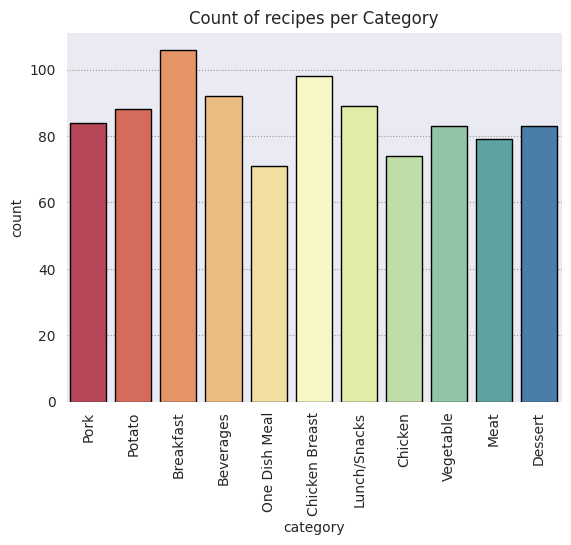

In [111]:
# Plot the amount of recipes per categories
sns.countplot(data=recipes, x='category', edgecolor='black',palette='Spectral')
plt.title('Count of recipes per Category')
plt.xticks(rotation=90)
plt.show()

/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


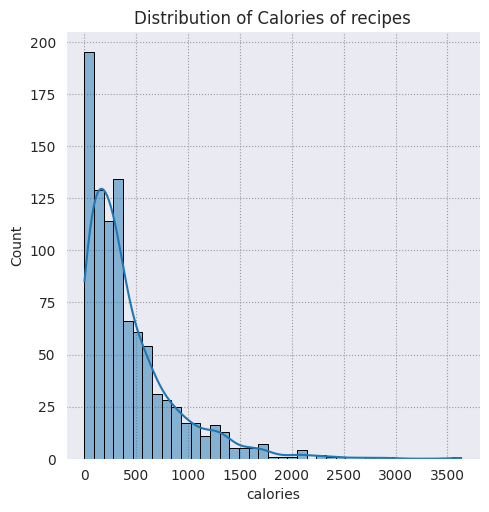

In [112]:
# Plot the distribution of calories
sns.displot(data=recipes, x='calories', kde=True, edgecolor='black')
plt.title('Distribution of Calories of recipes')
plt.show()

### Visualisation for multiple variables

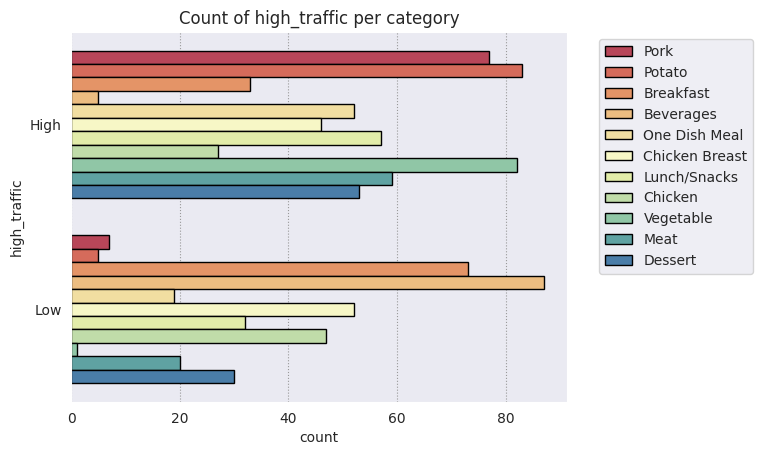

In [113]:
# Plot the most popular category for high_traffic recipes
sns.countplot(data=recipes, y='high_traffic', hue='category', palette='Spectral', edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Count of high_traffic per category')
plt.show()

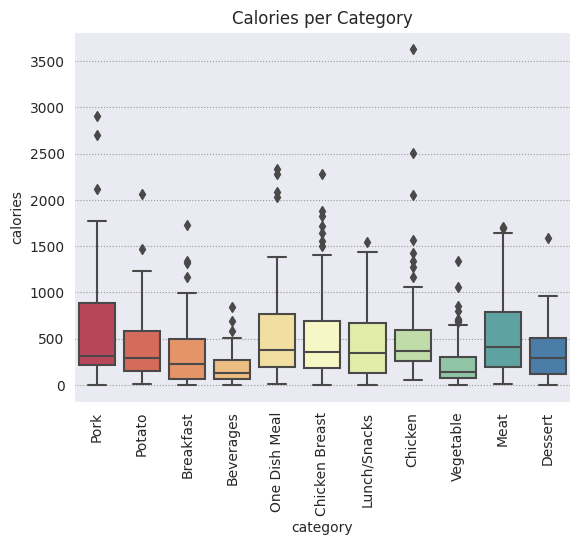

In [114]:
# Plot the calories per meal category
sns.boxplot(data=recipes, x='category', y='calories', palette='Spectral').set(title='Calories per Category')
plt.xticks(rotation=90)
plt.show()

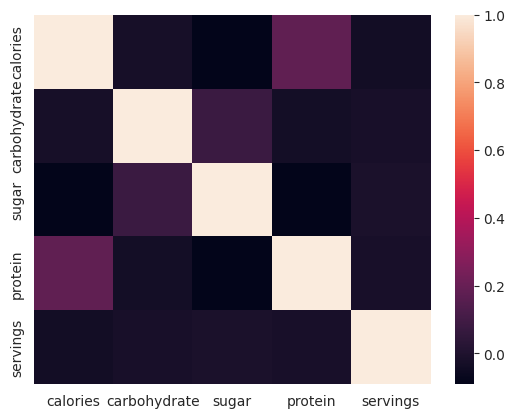

In [115]:
# Observing the correlation of the numeric variables
recipe_corr = recipes.select_dtypes(include=['number']).corr()
sns.heatmap(recipe_corr)
plt.show()

### Observations from the visualizations
-   The three recipes with most entries are Breakfast, Chiken Breast and Beverages
-   Most of the recipes have less than 1000 calories, with the majority being less than 500
-   Potato and Vegetable recipes tend to have the most amount of high traffic, with beverages being the less popular category
-   The recipes with the highest mean calories are meat recipes, with chicken recipes having an recipe with a very high amount of calories
    -   Beverages and Vegetables tend to have lower calories, with Beverages having a lower mean
- The outliers in the data don't seem to be erroneous data
- The correlation of the numeric data of the recipes is very weak

# Modeling the data for popularity prediction model
*   Define Target Variable
*   Prepare the data for the model, Scale and encode
*   Split the data into train and testing
*   Define wich kind of model to use (Compare models to see best fit for the data)
*   Prepare the model (Instanciate , Tune, Fit, Cross-validate, Predict, Evaluete)

### Target Variable
-   The Customer asked to predict recipes with high traffic
    -   The target is the 'high_traffic' column from the recipes dataset
    -   There are only two outcomes for the target variable 'High' == 1 and 'Low' == 0
    -   This is a classification problem

In [116]:
# Changing the target variable to 'high' = 1, 'Low' = 0
recipes['high_traffic'] = recipes['high_traffic'].replace({'High': 1, 'Low': 0})
recipes.high_traffic.value_counts()

high_traffic
1    574
0    373
Name: count, dtype: int64

* The target variable doesn't show a significant imbalance in it's proportion

### Spliting, encoding using One-Hot and scaling values
*   The 'category' column needs to be encoded
*   the numerical columns appresent a diverse range of values and needs to be scaled

In [117]:
# Define features 'X' and target 'y'

X = recipes.drop(columns=['high_traffic'])
y = recipes.high_traffic

# Selecting features to encode and scale

# Categorical 
cat_columns = X.select_dtypes(include = 'object').columns.tolist()
# Numerical 
num_columns = X.select_dtypes(include = ['number']).columns.tolist()

# Splitting
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=42)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Encoding and scaling
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Encoder
ohe_enc = OneHotEncoder(drop = 'first', handle_unknown= 'ignore')

# Scaler
scaler = RobustScaler()

# Column tranformer
transformer = ColumnTransformer( transformers = [
                                ('onehot', ohe_enc, cat_columns),
                                ('scaler', scaler, num_columns)
                                ])

# Fit-transform data
transformer.fit(X_train)
X_train_enc = transformer.transform(X_train)
X_test_enc = transformer.transform(X_test)

print('\ntransformed\n')
display(X_train_enc.shape, X_test_enc.shape)


(662, 6)

(285, 6)

(662,)

(285,)


transformed



(662, 15)

(285, 15)

### Models Selected

* **Random Forest Classifier** is a bagging ensemble of decision trees. It is known for its high accuracy and its ability to handle overfitting.
    * Strength: able to reduce variance by averaging the predictions of multiple decision trees
    * Weakness: can be computationally expensive
* **Gradient Boosting Classifier** is another ensemble of decision trees, but it is trained in a sequential manner. Each tree is trained to correct the errors of the previous trees.
    * Strength: more resistant to overfitting than Random Forest
    * Weakness: can be more computationally expensive
* **Extra Trees Classifier** is similar to Random Forest, but it uses a more randomized approach to building the decision trees.
    * Strength: even less prone to overfitting than Random Forest
    * Weakness: can be less accurate
* **AdaBoost Classifier** is an ensemble of weak learners, such as decision stumps. It works by iteratively training the weak learners to focus on the data points that are misclassified by the previous learners.
    * Strength: very good at correcting mistakes, can achieve high accuracy
    * Weakness: can be sensitive to outliers
* **Bagging Classifier** is an ensemble of decision trees where each tree is trained on a bootstrap sample of the training data. This helps to reduce the variance of the model and improve its generalization performance.
    * Strength: can be less computationally expensive than Random Forest
    * Weakness: can be less accurate than Random Forest
* **Logistic Regression** is a linear model that is commonly used for classification tasks. It works by finding the best fitting line or curve that separates the two classes of data.
    * Strength: can be very accurate and efficient
    * Weakness: can be sensitive to outliers
* **Decision Tree Classifier** is a non-parametric model that can be used for both classification and regression tasks. It works by recursively partitioning the data into smaller and smaller subsets until each subset is homogeneous.
    * Strength: can be very interpretable and easy to understand
    * Weakness: can be prone to overfitting

## Key Differences

| Model | Strengths | Weaknesses |
|---|---|---|
| Random Forest Classifier | High accuracy, good at handling overfitting | Can be computationally expensive |
| Gradient Boosting Classifier | More resistant to overfitting than Random Forest, can be more accurate | More computationally expensive |
| Extra Trees Classifier | Even less prone to overfitting than Random Forest, can be faster | Can be less accurate |
| AdaBoost Classifier | Very good at correcting mistakes, can achieve high accuracy | Can be sensitive to outliers |
| Bagging Classifier | Can be less computationally expensive than Random Forest | Can be less accurate than Random Forest |
| Logistic Regression | Can be very accurate and efficient | Can be sensitive to outliers |
| Decision Tree Classifier | Can be very interpretable and easy to understand | Can be prone to overfitting |


In [118]:
# Import and instanciate Models
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

rf_class = RandomForestClassifier(n_jobs=-1, random_state=42)
gb_class = GradientBoostingClassifier(random_state=42)
ext_class = ExtraTreesClassifier(random_state=42, n_jobs=-1)
ada_class = AdaBoostClassifier(random_state=42)
bagg_class = BaggingClassifier(random_state=42, n_jobs=-1)
log_class = LogisticRegression(random_state=42, n_jobs=-1)
dt_class = DecisionTreeClassifier(random_state=42)

* Check performance to filter models for finetunning of the best 2

In [123]:
from sklearn.model_selection import cross_val_score
import numpy as np
# Define the datasets
set_1 = (X_train_enc, y_train)

# Define the models
models = [rf_class, gb_class, ext_class, ada_class, bagg_class, log_class, dt_class]

# Define a dictionary to store the precision scores for each model and dataset
precision_scores = {'Scores': {}}

# Loop through the models
for model in models:
    model_name = model.__class__.__name__
    
    # Loop through the datasets
    for dataset_name, dataset in [('Scores', set_1)]:
        X, y = dataset
        
        # Calculate precision scores using cross-validation
        precision_scores[dataset_name][model_name] = cross_val_score(model, X, y, cv=20, scoring='precision', n_jobs=-1)
        

In [148]:
models = {}
# Print the precision scores
for dataset_name, model_scores in precision_scores.items():
    print(f"Precision Scores for {dataset_name}:")
    for model_name, scores in model_scores.items():
        models[model_name] = np.mean(scores) 
        print(f"{model_name}: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    print()

# Top performing models
print(f'Best performers: {list(dict(sorted(models.items(), key=lambda item: item[1], reverse=True)))[:2]}')


Precision Scores for Scores:
RandomForestClassifier: 0.7679 (±0.0588)
GradientBoostingClassifier: 0.7585 (±0.0498)
ExtraTreesClassifier: 0.7544 (±0.0670)
AdaBoostClassifier: 0.7516 (±0.0508)
BaggingClassifier: 0.7643 (±0.0565)
LogisticRegression: 0.7930 (±0.0659)
DecisionTreeClassifier: 0.7099 (±0.0497)

Best performers: ['LogisticRegression', 'RandomForestClassifier']


* The best two models were ['LogisticRegression', 'RandomForestClassifier']
    -   Using the two best performers for tunning the parameters

In [150]:
# Create param grids for the models
import numpy as np

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

log_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}


In [151]:
from sklearn.model_selection import GridSearchCV



# Grid search for Random Forest
rf_grid = GridSearchCV(rf_class, param_grid=rf_param_grid, n_jobs=-1, cv=10, verbose=1)
rf_grid.fit(X_train_enc, y_train)

# Grid search for Logistic Regression
log_grid = GridSearchCV(log_class, param_grid=log_param_grid, n_jobs=-1, cv=10, verbose=1)
log_grid.fit(X_train_enc, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


Fitting 10 folds for each of 60 candidates, totalling 600 fits


/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_mod

GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

In [153]:
# Check best parameters found for the models
print(rf_grid.best_params_, log_grid.best_params_)


# Set Optimized models
rf_model = RandomForestClassifier(**rf_grid.best_params_)
log_model = LogisticRegression(**log_grid.best_params_, n_jobs=-1)

# Fit the models
rf_model.fit(X_train_enc, y_train)
log_model.fit(X_train_enc, y_train)

# Generate predictions
rf_preds = rf_model.predict(X_test_enc)
log_preds = log_model.predict(X_test_enc)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300} {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/home/nero/Documents/Estudos/estudos/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


### Evaluation
-   Precision: Precision is the fraction of predicted positive instances that are actually positive
-   Accuracy: Accuracy is the fraction of all instances that are correctly classified
-   Recall: Recall is the fraction of actual positive instances that are correctly classified
-   F1 Score: The F1 score is a weighted harmonic mean of precision and recall
-   Confusion Matrix: Summarizes the performance of a classification model

In [154]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

metrics = [precision_score, accuracy_score, recall_score, f1_score, confusion_matrix]
scores_ada = {}
scores_log = {}
preds = [rf_preds, log_preds]

# Evaluation loop
for metric in metrics:
    score = metric(y_test, preds[0])
    scores_ada[metric.__name__] = score

for metric in metrics:
    score = metric(y_test, preds[1])
    scores_log[metric.__name__] = score

        
scores = pd.DataFrame([scores_ada, scores_log], index=['RandomForestClassifier', 'LogisticRegression']).T
scores.columns = ['RandomForestClassifier', 'LogisticRegression']
display(scores)


,RandomForestClassifier,LogisticRegression
precision_score,0.757732,0.80791
accuracy_score,0.726316,0.757895
recall_score,0.825843,0.803371
f1_score,0.790323,0.805634
confusion_matrix,"[[60, 47], [31, 147]]","[[73, 34], [35, 143]]"


# Choosen model
*   LogisticRegression model
*   Achieves the client demand of at least 80% precision
*   Has an overall good performance on the dataset

### Predict the top 10 most popular recipes

In [161]:
# Generate probabilities
y_proba = log_model.predict_proba(X_test_enc)[:,1]

top_reciped_df = pd.DataFrame(data={'recipe_code':y_test.index, 'pobability_of_success':y_proba}).set_index('recipe_code')
top_reciped_df.nlargest(n=10, columns=['pobability_of_success'])


,pobability_of_success
recipe_code,
102,0.985294
482,0.984142
887,0.983373
159,0.982542
465,0.981924
232,0.981811
826,0.981661
686,0.981424
821,0.981304
